# Metrics for Binary Classification

[Click here](https://neuronjolt.com/data/downloads/ch_13_classification_metrics.ipynb) to download this chapter as a Jupyter (.ipynb) file. 

This chapter introduces metrics other than simple accuracy that are useful for evaluating binary classification models.

## Module and Function Imports

In [1]:
import mglearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import get_scorer_names
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

## What's Wrong with Using Accuracy as the Performance Metric?

A classification model's accuracy is calculated as the number of correct predictions divided by the total number of predictions. In other words, accuracy is calculated as 100% minus the percentage of predictions that are mistakes or errors. Accuracy is often not the best metric with which to evaluate binary classifier performance. This is because the accuracy metric treats all errors as being equal, but we know that in most real prediction situations related to binary classification different types of errors are not equal; they have different costs and benefits.

### Types of errors

In binary classification we often call the class we are trying to predict the *positive* class and the other class the *negative* class. For example, if we were building a model to predict presence of cancer in a tissue sample cancerous would be the *positive* class and not cancerous would be the *negative* class. There are two types of binary classification errors:

1. ***False positive*** or ***type 1 error*** - predicting the positive class when the instance is actually a member of the negative class. In the cancer example a *false positive* would refer to classifying a tumor that is actually benign as a cancerous tumor.
2. ***False negative*** or ***type 2 error*** - predicting the negative class when the instance is actually a member of the positive class. In the cancer example a *false negative* would refer to classifying a tumor that is actually cancerous as benign.

As you can understand from the cancer example, these two types of errors rarely have the same costs, but accuracy as a metric treats both types of errors equally.  

### Imbalanced datasets

Datasets with very different percentages of the positive and negative classes are referred to as ***imbalanced datasets***.  On highly imbalanced datasets we can achieve high accuracy by simply always predicting the most prevalent class. However, such a model doesn't do what we want, which is usually to distinguish between the two classes. This is another reason why we might want to use a metric other than accuracy to evaluate our classification models.

## Comparison of the Accuracy of Different Classifiers on the Digits Data 

In this section we will use simple accuracy to compare the performance of various classification algorithms on the digits data. Later, to highlight the differences among various performance metrics we will use alternative metrics to compare the performance of those same classification algorithms on the digits dataset. 

### Load the digits data

Let's load the digits dataset, which has data on images of handwritten digits (0 - 9). The target value is the digit depicted in the image. We will make it a binary classification task by predicting if the digit is a 9.

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [4]:
digits.target.shape

(1797,)

In [5]:
digits.target[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
# Define y as the target variable for a model predicting 9s
y = digits.target == 9
y

array([False, False, False, ..., False,  True, False])

### Perform a stratified train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, 
                                                    y, 
                                                    stratify = y, 
                                                    random_state = 0)

In [8]:
# Calculate the percentage of the positive class (9s) in the data
np.mean(y_train == True)

0.10022271714922049

### Investigate simple accuracy of various classification algorithms

The `DummyClassifier` can be used to predict the most frequent class, or to make random predictions with the same percentages of the positive and negative class as are present in the training data.
Such predictions provide a base case to which to compare predictions from our machine learning models. 

Let's first look at simple accuracy for some `DummyClassifier` methods and other classification methods.  


In [9]:
# First try the strategy of predicting the most frequent value
dummy_most_frequent = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_most_frequent.predict(X_test)

In [10]:
# Verify that the predictions are all the most frequent class (False)
np.mean(pred_most_frequent == False)

1.0

In [11]:
# Calculate accuracy of the dummy_most_frequent classifier on the test data
dummy_most_frequent.score(X_test, y_test)

0.9

In [12]:
# Now try the 'stratified' strategy, which generates predictions randomly 
# according to the training set’s class distribution.
dummy_stratified = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_stratified = dummy_stratified.predict(X_test)

In [13]:
# Calculate accuracy of the dummy_stratified classifier on the test data
dummy_stratified.score(X_test, y_test)

0.8333333333333334

In [14]:
# Now let's look at a classification tree, with max_depth set to 3.
tree = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
tree.score(X_test, y_test)

0.9511111111111111

In [15]:
# Let's try logistic regression with the regularization parameter C set
# to 0.1. The strength of regularization is inversely proportional to `C`, so 
# higher values of C results in less regularization.
logreg = LogisticRegression(C = 0.1, max_iter = 3_000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
logreg.score(X_test, y_test)

0.9822222222222222

## Confusion Matrices

Confusion matrices are a tool that help us to evaluate binary classifier performance by splitting out counts of the various types of correct decisions and errors made. Confusion matrices for binary classification are a 2z2 matrix.  

### Graph of Counts of Correct Predictions and Errors on Confusion Matrix

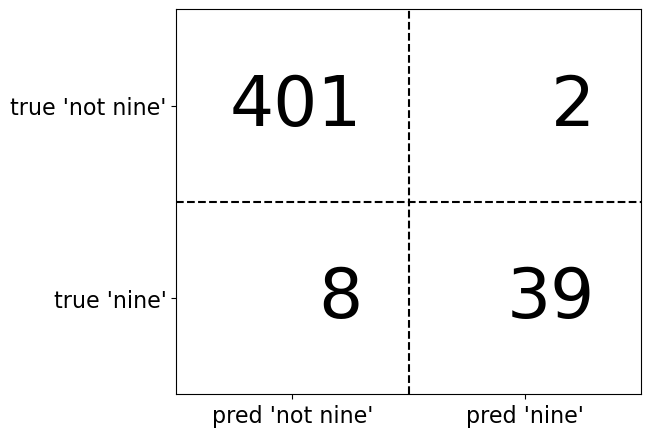

In [16]:
plt.figure(figsize=(6, 5))
confusion = np.array([[401, 2], [8, 39]])
plt.text(0.40, .7, confusion[0, 0], size=50, horizontalalignment='right')
plt.text(0.40, .2, confusion[1, 0], size=50, horizontalalignment='right')
plt.text(.90, .7, confusion[0, 1], size=50, horizontalalignment='right')
plt.text(.90, 0.2, confusion[1, 1], size=50, horizontalalignment='right')
plt.xticks([.25, .75], ["pred 'not nine'", "pred 'nine'"], size=16)
plt.yticks([.25, .75], ["true 'nine'", "true 'not nine'"], size=16)
plt.plot([.5, .5], [0, 1], '--', c='k')
plt.plot([0, 1], [.5, .5], '--', c='k')

plt.xlim(0, 1)
plt.ylim(0, 1);

### Graph of Types of Errors and Correct Predictions on Confusion Matrix

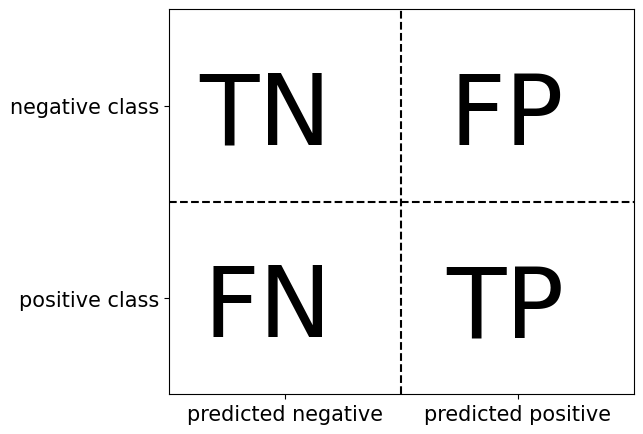

In [17]:
plt.figure(figsize=(6, 5))

plt.text(0.35, .65, "TN", size=70, horizontalalignment='right')
plt.text(0.35, .15, "FN", size=70, horizontalalignment='right')
plt.text(.85, .65, "FP", size=70, horizontalalignment='right')
plt.text(.85, .15, "TP", size=70, horizontalalignment='right')
plt.xticks([.25, .75], ["predicted negative", "predicted positive"], size=15)
plt.yticks([.25, .75], ["positive class", "negative class"], size=15)
plt.plot([.5, .5], [0, 1], '--', c='k')
plt.plot([0, 1], [.5, .5], '--', c='k')

plt.xlim(0, 1)
plt.ylim(0, 1);

We can use the scikit-learn `confusion_matrix()` function to return the counts in the confusion matrix.

### A closer look at the performance of the algorithms we ran on the digits data

#### Confusion Matrix for Logistic Regression Model

The `confusion_matrix()` method creates a 2-dimensional array of the confusion matrix numbers. It can be displayed as an array or plotted with the `ConfusionMatrixDisplay` object. Note that the `ConfusionMatrixDisplay` object also has `from_predictions()` and `from_estimator()` methods to plot the confusion matrix directly from the predictions and the true values, or from the estimator and the data. The methods for plotting from the predictions or from the estimator have more options. They can display counts, row percentages, column percentages, or overall percentages.

In [18]:
confusion = confusion_matrix(y_test, pred_logreg)
confusion

array([[402,   3],
       [  5,  40]])

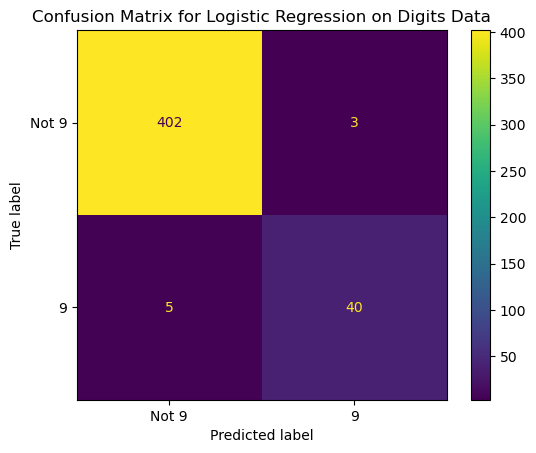

In [19]:
# We can plot a confusion matrix from the confusion matrix array

disp = ConfusionMatrixDisplay(confusion_matrix = confusion,
                              # display_labels = logreg.classes_)
                              display_labels = ['Not 9', '9'])
disp.plot()
plt.title('Confusion Matrix for Logistic Regression on Digits Data');

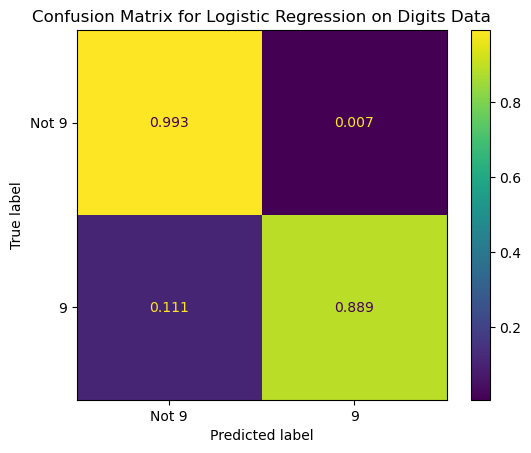

In [20]:
# We can also plot a confusion matrix from the predictions
# Note the use of normalize = 'true' here to replace 
# the counts with percentages (row-wise)
ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = pred_logreg ,
                                        display_labels = ['Not 9', '9'],
                                        values_format = '.3f',
                                        normalize = 'true')

plt.title('Confusion Matrix for Logistic Regression on Digits Data');

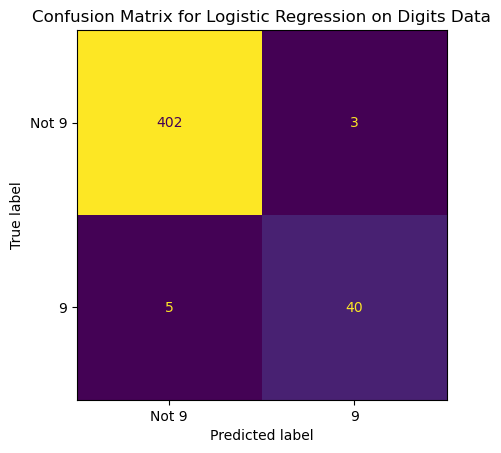

In [21]:
# We can also plot a confusion matrix from the estimator and the data

ConfusionMatrixDisplay.from_estimator(estimator = logreg, 
                                      X = X_test,
                                      y = y_test,
                                      display_labels = ['Not 9', '9'],
                                      normalize = None,
                                      colorbar = False)

plt.title('Confusion Matrix for Logistic Regression on Digits Data');

#### Confusion Matrix for Model that Predicts Most Frequent Class

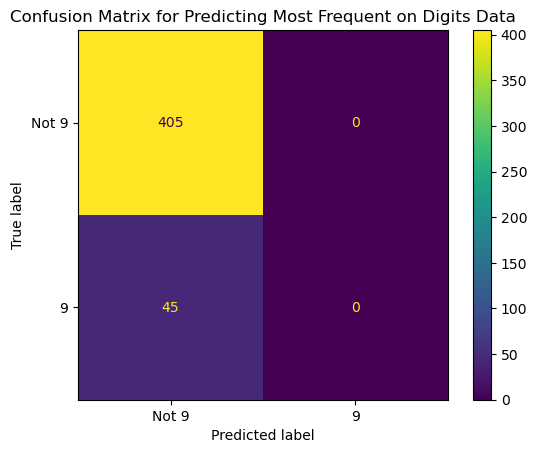

In [22]:
confusion_mf = confusion_matrix(y_test, pred_most_frequent)

disp = ConfusionMatrixDisplay(confusion_matrix = confusion_mf,
                              display_labels = ['Not 9', '9'])
disp.plot()
plt.title('Confusion Matrix for Predicting Most Frequent on Digits Data');

#### Confusion Matrix for Random Predictions According to the Training Set’s Class Distribution.

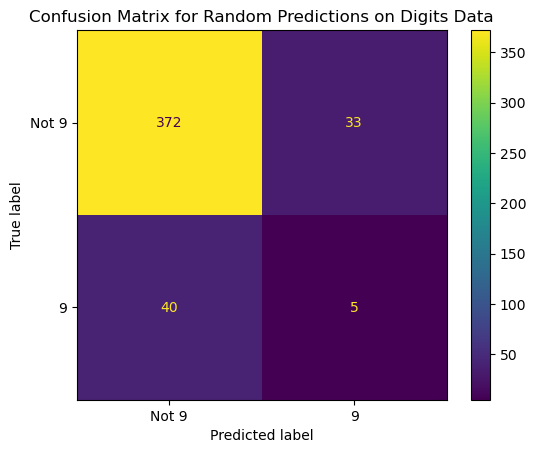

In [23]:
confusion_stratified = confusion_matrix(y_test, pred_stratified)

disp = ConfusionMatrixDisplay(confusion_matrix = confusion_stratified,
                              display_labels = ['Not 9', '9'])
disp.plot()
plt.title('Confusion Matrix for Random Predictions on Digits Data');

#### Confusion Matrix for Decision Tree Model

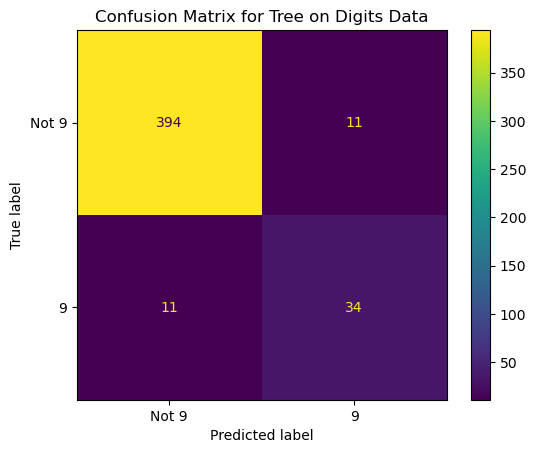

In [24]:
confusion_matrix(y_test, pred_tree)
confusion_tree = confusion_matrix(y_test, pred_tree)

disp = ConfusionMatrixDisplay(confusion_matrix = confusion_tree,
                              display_labels = ['Not 9', '9'])
disp.plot()
plt.title('Confusion Matrix for Tree on Digits Data');

## Metrics based on the confusion matrix

**There are several metrics that can be calculated from the four components of the confusion matrix (TP, FP, TN, FN)**

**Simple Accuracy:**

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

**Precision**, also known as *positive predicted value (PPV)*, measures the percentage of samples predicted to be positive that are actually positive. It is used when it is important to limit the number of false positives.

$Precision = \frac{TP}{TP+FP}$

**Recall**, also called *sensitivity*, *hit rate*, and *true positive rate (TPR)*, measures the percentage of samples that are actually positive that are predicted to be positive. Used when it is important to identify as many of the positive samples as possible, such as with a cancer test.

$Recall = \frac{TP}{TP+FN}$

The **false positive rate (FPR)** is the percentage samples that are actually negative that are predicted to be positive.

$FPR = \frac{FP}{FP+TN}$

There is a tradeoff between optimizing for precision and optimizing for recall. The **f-score** or **f-measure** is the harmonic mean of precision and recall. This particular variant of the f-measure is known as the $f_1 score$.

$F = 2 \times \frac{precision \times recall}{precision + recall}$

#### Let's calculate the $f_1 score$ for the predictions we made earlier
**Note how the $f_1 score$ distinguishes between the models much better than simple accuracy.**

In [25]:
print("f1 score most frequent: {:.2f}".format(
      f1_score(y_test, pred_most_frequent)))
print("f1 score predicting at random: {:.2f}".format(
      f1_score(y_test, pred_stratified)))
print("f1 score tree: {:.2f}".format(
      f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(
      f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score predicting at random: 0.12
f1 score tree: 0.76
f1 score logistic regression: 0.91


### The `classification_report` function gives us several metrics at once

In [26]:
print(classification_report(y_test, pred_tree,
                            target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.97      0.97      0.97       405
        nine       0.76      0.76      0.76        45

    accuracy                           0.95       450
   macro avg       0.86      0.86      0.86       450
weighted avg       0.95      0.95      0.95       450



The `classification_report` function produces a set of metrics for each class as the positive class. `support` simply refers to the number of samples in each class. The `macro avg` is the simple average across classes. The `weighted avg` is the weighted average across the classes.

## Taking uncertainty into account

The metrics we have seen so far are based on binary predictions, but most classification models can produce scores or probabilities via the `decision_function()` or `predict_proba()` methods. A binary class prediction can be understood as a combination of a score or probability and a threshold. In binary classification the threshold is typically set to 0 for the decision function and 0.5 for the predicted probability. The probabilities produced by classification models are not always very well calibrated, so we can sometimes improve performance on our metric of interest by adjusting the classification thresholds.

In [27]:
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

knn = KNeighborsClassifier(n_neighbors = 35).fit(X_train, y_train)

See the probabilities of the positive class produced by the Knn model. 0.50 is the default probability threshold. Instances with probability of the positive class of 0.50 or higher will be classified as the positive class (1) and instances with probability of the positive class of less than 0.50 will be classified as the negative class (0).

In [28]:
knn.predict_proba(X_test)[:5]

array([[1.        , 0.        ],
       [0.28571429, 0.71428571],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [29]:
knn.predict(X_test)[:5]

array([0, 1, 0, 0, 0])

## Receiver operating characteristics (ROC) and AUC

A popular tool for evaluating classifiers across all thresholds is the *receiver operating characteristics curve* or *ROC curve*. It displays the false positive rate (FPR) against the true positive rate (TPR). The `roc_curve` method can be used to calculate the false positive rate and true positive rate at all the possible thresholds.

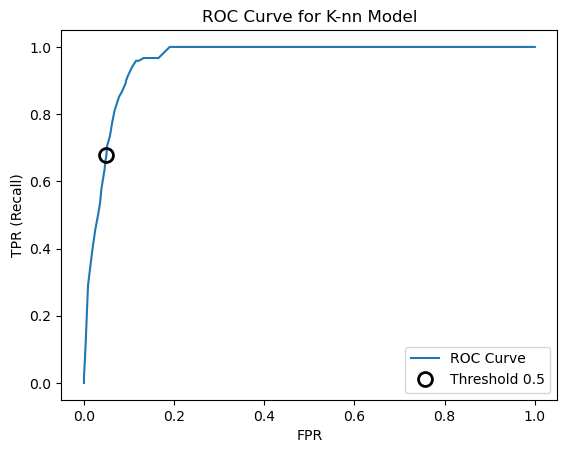

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')

# Find threshold closest to 0.50
close_default = np.argmin(np.abs(thresholds - 0.5))

plt.plot(fpr[close_default], tpr[close_default], 'o', markersize=10, label='Threshold 0.5',
         fillstyle='none', c='k', mew=2)
plt.legend(loc=4)
plt.title('ROC Curve for K-nn Model');


### Plot ROC curves for both K-nn and random forest classifiers

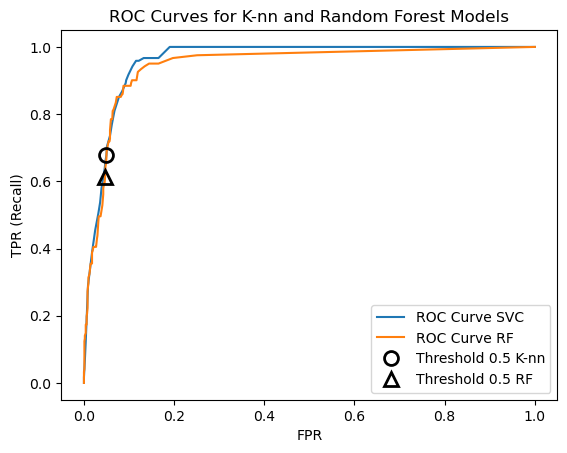

In [31]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label='ROC Curve SVC')
plt.plot(fpr_rf, tpr_rf, label='ROC Curve RF')

plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.plot(fpr[close_default], tpr[close_default], 'o', markersize=10, label='Threshold 0.5 K-nn',
         fillstyle='none', c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label='Threshold 0.5 RF', fillstyle='none', c='k', mew=2)

plt.legend(loc=4)
plt.title('ROC Curves for K-nn and Random Forest Models');

### The area under the ROC curve is often used as a metric, called the AUC ("Area under ROC Curve")

AUC is always between 0 and 1. Predicting randomly always produces an AUC with an expected value of 0.50.
AUC is a better metric than simple accuracy for imbalanced classes. ***You can think of AUC as the probability that a randomly-selected point of the positive class will have a higher score (probability or ranking indicating likelihood of membership in the positive class) according to the classifier than a randomly-selected point of the negative class.***

In [32]:
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
print('AUC for Random Forest: {:.3f}'.format(rf_auc))
print('AUC for Knn: {:.3f}'.format(knn_auc))

AUC for Random Forest: 0.945
AUC for Knn: 0.960


### A note about metrics for regression models
In most cases the default metric $R^2$ is sufficient for evaluating regression models. Sometimes mean squared error or mean absolute error is used instead.

## Using metrics like AUC in model selection when using `cross_validate` or `GridSearchCV`
These have a `scoring` parameter that can be set to the metric you want to use. 

### With `cross_validate`
You can specify the metric by using one of the pre-defined strings listed [in the scikit-learn documentation here](https://scikit-learn.org/stable/modules/model_evaluation.html), or you can even define your own scoring function and use that.

In [33]:
# Load the digits dataset again
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y)

In [34]:
# default scoring for classification is accuracy
result_acc = cross_validate(estimator = KNeighborsClassifier(n_neighbors = 35), 
                            X = digits.data, 
                            y = digits.target==9, 
                            cv = 5)

print("Accuracy:", result_acc['test_score'].mean())

Accuracy: 0.9760817084493965


In [35]:
# Now let's try roc_auc score as the metric
result_roc = cross_validate(estimator = KNeighborsClassifier(n_neighbors = 35), 
                            X = digits.data, 
                            y = digits.target==9, 
                            cv = 5,
                            scoring = 'roc_auc')

print("ROC AUC:", result_roc['test_score'].mean())

ROC AUC: 0.9941035792701312


### With the `cross_validate` function we can also compute several metrics at once

In [36]:
res = cross_validate(estimator = KNeighborsClassifier(n_neighbors = 35), 
                     X = digits.data, 
                     y = digits.target==9,
                     cv = 5,
                     scoring=['accuracy', 'average_precision', 'recall_macro'])

pd.DataFrame(res)

fit_time  score_time  test_accuracy  test_average_precision  \
0  0.001212    0.018614       0.972222                0.939807   
1  0.000885    0.019603       0.961111                0.912051   
2  0.000869    0.015776       0.983287                0.983611   
3  0.000870    0.015507       0.988858                0.994133   
4  0.000863    0.015506       0.974930                0.952274   

   test_recall_macro  
0           0.873457  
1           0.830247  
2           0.929008  
3           0.944444  
4           0.875000

### We can also change the metric used to pick the best parameters in `GridSearchCV`

#### first use default metric, accuracy

In [37]:
param_grid = {'n_neighbors': range(3, 22, 2)}

gs = GridSearchCV(estimator = KNeighborsClassifier(),
                  param_grid = param_grid,
                  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5))
                  
gs.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 22, 2)})

In [38]:
print("Grid search with accuracy")
print("Best parameters:", gs.best_params_)
print("Best cross validation score (accuracy): {:.3f}".format(gs.best_score_))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, gs.predict(X_test))))

Grid search with accuracy
Best parameters: {'n_neighbors': 5}
Best cross validation score (accuracy): 0.995
Test set accuracy: 0.998


#### Now use AUC as the metric instead of accuracy

In [39]:
grid = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = param_grid,
                    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5),
                    scoring = 'roc_auc')
                  
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 22, 2)}, scoring='roc_auc')

In [40]:
print("Grid search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, grid.predict(X_test))))

Grid search with AUC
Best parameters: {'n_neighbors': 11}
Best cross validation score (AUC): 0.999
Test set accuracy: 0.998


### List of the various metrics that you can use in scikit-learn

In [41]:
sorted(get_scorer_names())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall